In [1]:
import mlflow
import mlflow.artifacts
from revision_utils import TRACKING_URI, RUN_ASC3_W_RANKNET, RUN_ASC3_WO_RANKNET, FOLD_RESULTS_PICKLE

mlflow.set_tracking_uri(TRACKING_URI)

result_w_ranknet_path = mlflow.artifacts.download_artifacts(FOLD_RESULTS_PICKLE.format(run_id=RUN_ASC3_W_RANKNET))
result_wo_ranknet_path = mlflow.artifacts.download_artifacts(FOLD_RESULTS_PICKLE.format(run_id=RUN_ASC3_WO_RANKNET))

In [2]:
from revision_utils import open_pickle
result_w_ranknet = open_pickle(result_w_ranknet_path)
result_wo_ranknet = open_pickle(result_wo_ranknet_path)

In [17]:
import os
import sys

import pandas as pd
revision_dir = os.getcwd()
result_dir = os.path.dirname(revision_dir)
root_dir = os.path.dirname(result_dir)

sys.path.append(root_dir)
from core.metric import Metric

rows = list()
method_names = ["3ASC W/ RankNet", "3ASC W/O RankNet"]
for method, fold_result in zip(method_names, [result_w_ranknet, result_wo_ranknet]):
    for fold in range(0, 5):
        for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]:
            value = Metric.topk_recall(
                bag_labels=fold_result["fold_bag_y_trues"][fold],
                instance_labels=fold_result["fold_instance_y_trues"][fold],
                instance_probs=fold_result["fold_instance_y_probs"][fold],
                k=k,
                is_any=True
            )
            rows.append([method, fold, k, value])
            
data = pd.DataFrame(rows, columns=["loss", "fold", "K", "HitRate@K\n(SNV+CNV)"])
data.head()

,loss,fold,K,HitRate@K\n(SNV+CNV)
0,3ASC W/ RankNet,0,1,0.766728
1,3ASC W/ RankNet,0,2,0.896255
2,3ASC W/ RankNet,0,3,0.939840
3,3ASC W/ RankNet,0,4,0.960712
4,3ASC W/ RankNet,0,5,0.970534


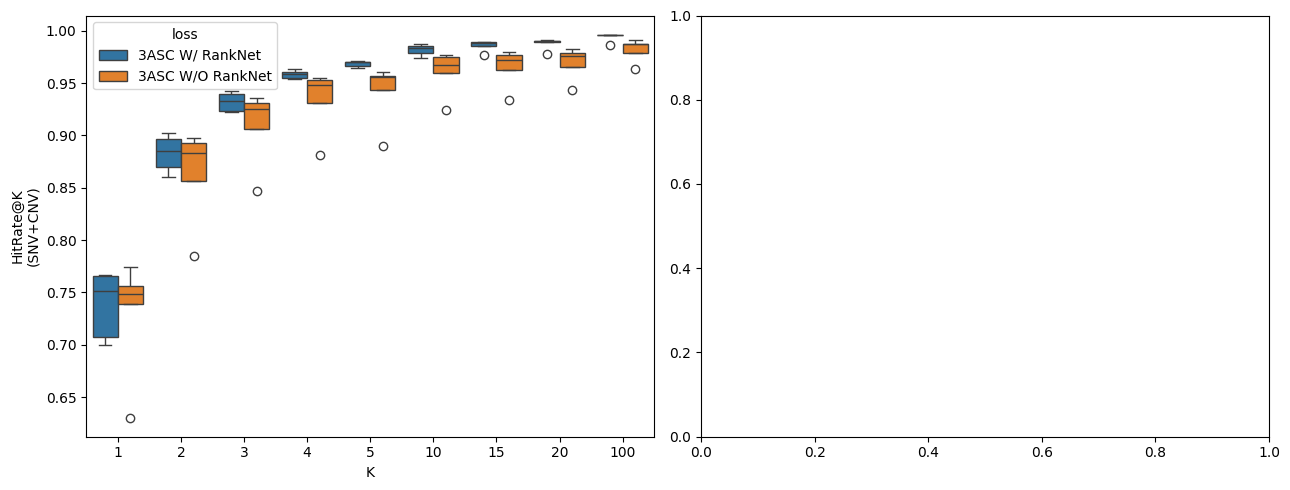

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.boxplot(
    data=data,
    x="K",
    y="HitRate@K\n(SNV+CNV)",
    hue="loss", 
    ax=axes[0]
)

plt.tight_layout()
plt.show()

: 